In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 200

import japanize_matplotlib

import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

sns.set(font="IPAexGothic")

from IPython.display import display
import collections
import re
import feather
import codecs
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import PowerTransformer

In [22]:
train=pd.read_csv('../input/train.csv')
test=pd.read_csv('../input/test.csv')
df_all=pd.concat([train,test],axis=0,sort=False).reset_index(drop=True)
df_all.columns=['id','rent','address','access','floor_info','old','direction','square','floor','bath','kitchen','broadcast','facility','parking','neighbors','structure','period']

train_feat4=pd.read_feather('feature4/data/train_feat4_all.ftr')
test_feat4=pd.read_feather('feature4/data/test_feat4_all.ftr').drop('index',axis=1)
df_all_feat4=pd.concat([train_feat4,test_feat4],axis=0,sort=False).reset_index(drop=True)
train_index=len(train_feat4)
test_index=len(test_feat4)

##  連続値を正規分布に載せる

In [23]:
#  駅までの距離を平均値で補完
df_all_feat4['access_2_distance']=df_all_feat4['access_2_distance'].replace(-999,df_all_feat4.query('access_2_distance!=-999')['access_2_distance'].mean())

log_cols=['rent','others_rent','square_num','access_1_distance','access_2_distance','old_num','Square/Room','room_number']
for col in log_cols:
    df_all_feat4[col+'_log']=np.log1p(df_all_feat4[col])
    train_feat4[col+'_log']=np.log1p(train_feat4[col])  

## もっとも近いアクセスの最寄り駅情報を追加

In [24]:
dist_1over2=df_all_feat4['access_1_distance']<=df_all_feat4['access_2_distance']
dist_2over1=[not i for i in dist_1over2]

df_all_feat4['nearest_distance']=-999
df_all_feat4['nearest_line']=-999
df_all_feat4['nearest_station']=-999

df_all_feat4.loc[dist_1over2,'nearest_distance']=df_all_feat4[dist_1over2]['access_1_distance']
df_all_feat4.loc[dist_2over1,'nearest_distance']=df_all_feat4[dist_2over1]['access_2_distance']
df_all_feat4['nearest_distance_log']=np.log1p(df_all_feat4['nearest_distance'])


df_all_feat4.loc[dist_1over2,'nearest_line']=df_all_feat4[dist_1over2]['access_1_line']
df_all_feat4.loc[dist_2over1,'nearest_line']=df_all_feat4[dist_2over1]['access_2_line']

df_all_feat4.loc[dist_1over2,'nearest_station']=df_all_feat4[dist_1over2]['access_1_station']
df_all_feat4.loc[dist_2over1,'nearest_station']=df_all_feat4[dist_2over1]['access_2_station']


##  最上階かどうかの判定

In [31]:
is_top_room=df_all_feat4['room_floor']==df_all_feat4['building_floor']
df_all_feat4['is_top_room']=0
df_all_feat4.loc[is_top_room,'is_top_room']=1

## 相互作用特徴量を加える

In [32]:
# 自室の階と建物の階の積をとる
tmp=df_all_feat4['room_floor']==-999
tmp2=df_all_feat4['building_floor']==-999
room_building_mul=[ not i for i in (tmp | tmp2)]

df_all_feat4['room_building_mul']=-999
df_all_feat4.loc[room_building_mul,'room_building_mul']=df_all_feat4[room_building_mul]['room_floor']*df_all_feat4[room_building_mul]['building_floor']

room_floor_null=df_all_feat4['room_floor']==-999
room_floor_nonnull=[not i for i in room_floor_null]

df_all_feat4['square_log_building_mul']=-999
df_all_feat4.loc[room_floor_nonnull,'square_log_building_mul']=df_all_feat4[room_floor_nonnull]['building_floor']*df_all_feat4[room_floor_nonnull]['square_num_log']

In [33]:
# ルーム情報
df_all_feat4['Square_log/R']=df_all_feat4['square_num_log']/df_all_feat4['R']
df_all_feat4['R_K_mul']=df_all_feat4['R']*df_all_feat4['K']
df_all_feat4['R_DK_mul']=df_all_feat4['R']*df_all_feat4['DK']
df_all_feat4['R_LDK_mul']=df_all_feat4['R']*df_all_feat4['LDK']

df_all_feat4['simple_room_sum']=df_all_feat4['R']+df_all_feat4['K']+df_all_feat4['DK']+df_all_feat4['LDK']
df_all_feat4['Square_log/simple_room_sum']=df_all_feat4['square_num_log']/df_all_feat4['simple_room_sum']
df_all_feat4['Square_log/room_number']=df_all_feat4['square_num_log']/df_all_feat4['room_number']

In [34]:
# 区ごとの面積の平均値との差をとる
city_squarelog_mean=train_feat4.groupby('address_city_enc')['square_num_log'].agg({'mean'}).reset_index()
city_squarelog_mean.columns=['address_city_enc','city_square_log_mean']
df_all_feat4=pd.merge(df_all_feat4,city_squarelog_mean,on='address_city_enc',how='left')
df_all_feat4['city_squarelog_mean_diff']=df_all_feat4['square_num_log']-df_all_feat4['city_square_log_mean']

## ========保存============

In [35]:
feat6_unique=['rent_log', 'others_rent_log',
       'square_num_log', 'access_1_distance_log', 'access_2_distance_log',
       'old_num_log', 'Square/Room_log', 'room_number_log', 'nearest_distance',
       'nearest_line', 'nearest_station', 'nearest_distance_log',
       'is_top_room', 'room_building_mul',
       'square_log_building_mul', 'Square_log/R', 'R_K_mul', 'R_DK_mul',
       'R_LDK_mul', 'simple_room_sum', 'Square_log/simple_room_sum','Square_log/room_number',
         'city_square_log_mean','city_squarelog_mean_diff']

In [36]:
train_feat6=df_all_feat4[:train_index]
test_feat6=df_all_feat4[train_index:]

train_feat6[feat6_unique].to_feather('feature6/data/train_feat6_unique.ftr')
test_feat6.reset_index(drop=True,inplace=True)
test_feat6[feat6_unique].to_feather('feature6/data/test_feat6_unique.ftr')

## 他の特徴量全体で保存

In [37]:
for col in log_cols:
    train_feat6.drop(col,axis=1,inplace=True)
    test_feat6.drop(col,axis=1,inplace=True)

In [38]:
train_feat6.to_feather('feature6/data/train_feat6_all.ftr')
test_feat6.to_feather('feature6/data/test_feat6_all.ftr')

In [220]:
# Target Encdoding用にカテゴリー変数を保存

category_cols=['access_1_line','access_1_station','access_2_line','access_2_station',
              'direction_enc','macro_structure','floor_info_macro_structure',
              'address_city_enc','address_town_enc','mesh_category_enc','nearest_line','nearest_station']

f = open('feature6/data/feat6_category.pickle', 'wb')
pickle.dump(category_cols, f)
f.close()

In [221]:
train_feat6

,id,access_1_line,access_1_station,access_2_line,access_2_station,room_floor,building_floor,underground,total_floor,is_parking_car,is_house_parking_car,is_other_parking_car,parking_number_car,parking_price_car,is_parking_bicycle,is_house_parking_bicycle,is_other_parking_bicycle,parking_number_bicycle,parking_price_bicycle,is_parking_bike,is_house_parking_bike,is_other_parking_bike,parking_number_bike,parking_price_bike,convenience_count,supermarket_count,neighbor_count,デパート,幼稚園・保育園,図書館,ドラッグストア,郵便局,大学,公園,スーパー,銀行,コインパーキング,レンタルビデオ,飲食店,小学校,コンビニ,病院,総合病院,月極駐車場,クリーニング,学校,direction_enc,macro_structure,resistance_period,available_period,available_is_over,is_rent,period_num,future_available,future_available_is_over,floor_info_macro_structure,シャワー,トイレなし,トイレ別,バスなし,共同トイレ,共同バス,専用トイレ,専用バス,洗面台独立,浴室乾燥機,温水洗浄便座,脱衣所,追焚機能,ihコンロ,l字キッチン,カウンターキッチン,ガスコンロ,コンロ1口,コンロ2口,コンロ3口,コンロ4口以上,コンロ設置可,システムキッチン,冷蔵庫あり,口数不明,独立キッチン,給湯,電気コンロ,bsアンテナ,catv,csアンテナ,インターネット使用料無料,インターネット対応,光ファイバー,有線放送,高速インターネット,24時間換気システム,2面採光,3面採光,ウォークインクローゼット,エアコン付,エレベーター,オール電化,ガスその他,ガス暖房,クッションフロア,シューズボックス,タイル張り,トランクルーム,バリアフリー,バルコニー,フローリング,プロパンガス,ペアガラス,ルーフバルコニー,ロフト付き,下水,二世帯住宅,二重サッシ,井戸,公営水道,冷房,出窓,地下室,室内洗濯機置場,室外洗濯機置場,専用庭,床下収納,床暖房,排水その他,敷地内ごみ置き場,水道その他,汲み取り,洗濯機置場なし,浄化槽,石油暖房,都市ガス,防音室,longitude,latitude,address_city_enc,address_town_enc,R,K,DK,LDK,S,mesh_category_enc,rent_log,others_rent_log,square_num_log,access_1_distance_log,access_2_distance_log,old_num_log,Square/Room_log,room_number_log,nearest_distance,nearest_line,nearest_station,nearest_distance_log,is_top_room,room_building_mul,square_log_building_mul,Square_log/R,R_K_mul,R_DK_mul,R_LDK_mul,simple_room_sum,Square_log/simple_room_sum,Square_log/room_number,city_square_log_mean,city_squarelog_mean_diff
0,1,59,433,25,289,1,12,0,12,-999,-999,-999,-999,-999.0,1,1,0,1,-999.0,-999,-999,-999,-999,-999.0,1,2,10,0,0,0,956,1246,461,1103,311,0,0,0,378,495,588,0,0,0,0,0,5,4,564,446,0,0,24,422,0,96,1,0,1,0,0,0,1,1,0,1,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,35.746889,139.731307,3,1914,1,1,0,0,0,515,11.225257,0.000000,3.044999,5.771441,7.021976,4.779123,2.691746,0.897918,320.0,59,433,5.771441,0,12,36.539982,3.044999,1,0,0,2,1.522499,2.093520,3.384301,-0.339302
1,2,60,97,32,251,5,10,0,10,0,0,0,0,-999.0,1,1,0,1,-999.0,0,0,0,0,-999.0,0,1,1,0,0,0,0,0,0,0,1283,0,0,0,0,0,0,0,0,0,0,0,0,2,324,-215,1,0,24,-239,1,114,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,35.660879,139.778811,1,1368,1,0,0,0,0,715,11.238502,0.000000,2.862201,5.993961,6.580639,6.291569,2.862201,0.693147,400.0,60,97,5.993961,0,50,28.622009,2.862201,0,0,0,1,2.862201,2.862201,3.680058,-0.817857
2,3,17,383,17,80,12,15,0,15,1,0,1,1,30000.0,1,1,0,1,-999.0,1,1,0,1,-999.0,2,2,4,0,0,0,0,0,0,0,89,0,0,0,0,0,184,0,0,0,0,0,4,4,564,461,0,0,24,437,0,96,1,0,1,0,0,0,1,1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,35.675199,139.666064,15,2179,1,1,0,0,0,147,11.608245,10.905956,3.137666,6.175867,6.329721,4.644391,2.782538,0.897918,480.0,17,383,6.175867,0,180,47.064987,3.137666,1,0,0,2,1.568833,2.157231,3.508224,-0.370558
3,4,54,497,6,235,3,4,0,4,0,0,0,0,-999.0,0,0,0,0,-999.0,0,0,0,0,-999.0,2,4,6,0,0,0,0,0,0,0,225,0,0,0,0,0,326,0,0,0,0,0,4,4,564,211,0,1,24,187,0,13,1,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,35.700157,139.650554,11,2824,2,0,0,1,0,85,11.918397,0.000000,4.118712,6.580639,5.484797,5.869297,2.846717,1.553116,240.0,6,235,5.484797,0,12,16.474848,2.059356,0,0,2,3,1.372904,1.105346,3.355182,0.763530
4,5,13,69,29,470,1,2,0,2,1,0,1,1,17000.0,0,0,0,0,-999.0,0,0,0,0,-999.0,1,4,5,0,0,0,0,0,0,0,193,0,0,0,0,0,351,0,0,0,0,0,4,1,264,-116,1,0,24,-140,1,119,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1

In [224]:
f = open('feature6/data/feat6_category.pickle','rb')
cat_list=pickle.load(f)
train_feat4.loc[:,cat_list]

,access_1_line,access_1_station,access_2_line,access_2_station,direction_enc,macro_structure,floor_info_macro_structure,address_city_enc,address_town_enc,mesh_category_enc,nearest_line,nearest_station
0,59,433,25,289,5,4,96,3,1914,515,NaN,NaN
1,60,97,32,251,0,2,114,1,1368,715,NaN,NaN
2,17,383,17,80,4,4,96,15,2179,147,NaN,NaN
3,54,497,6,235,4,4,13,11,2824,85,NaN,NaN
4,13,69,29,470,4,1,119,20,2700,1093,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
31456,59,421,59,428,4,2,120,12,2359,199,NaN,NaN
31457,41,15,36,431,8,4,116,0,985,142,NaN,NaN
31458,49,117,61,149,4,2,22,14,703,902,NaN,NaN
31459,4,45,6,212,4,1,42,2,273,151,NaN,NaN


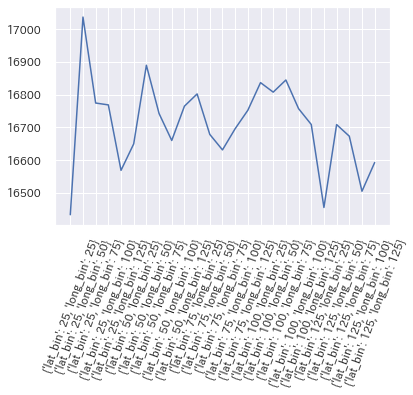

In [3]:
df=pd.read_csv('feature6/model/grid_params_rmse.csv').drop('Unnamed: 0',axis=1)
y=df.values
X=df.columns
plt.xticks(rotation=70,)
plt.plot(X,y.reshape(-1,1))
plt.show()

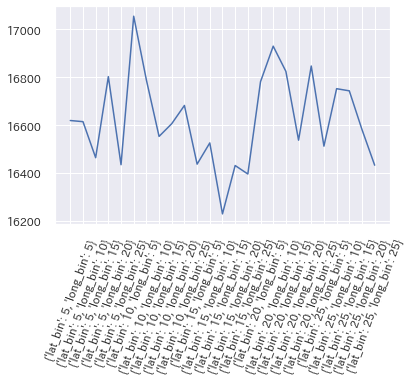

In [5]:
df=pd.read_csv('feature6/model/grid_params_rmse2.csv').drop('Unnamed: 0',axis=1)
y=df.values
X=df.columns
plt.xticks(rotation=70,)
plt.plot(X,y.reshape(-1,1))
plt.show()

In [8]:
df.columns[np.argmin(df.values)]

"{'lat_bin': 15, 'long_bin': 15}"